In [59]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import keras.layers as ks
from keras.models import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# Exercise 1

In [11]:
(x_data, _), (_, _) = cifar10.load_data()

In [112]:
x_data = x_data.reshape((len(x_data), 32, 32, 3))
x_train, x_temp, _, _ = train_test_split(x_data, x_data, test_size=0.2, random_state=42)
x_val, x_test, _, _ = train_test_split(x_temp, x_temp, test_size=0.5, random_state=42)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_gray = np.array([np.dot(image[...,:3], [0.299, 0.587, 0.114]) for image in x_train])
x_train_gray = x_train_gray.reshape(40000,32,32,1)
x_val_gray = np.array([np.dot(image[...,:3], [0.299, 0.587, 0.114]) for image in x_val])
x_val_gray = x_val_gray.reshape(5000,32,32,1)

In [113]:
x_val.shape

(5000, 32, 32, 3)

In [117]:
x_val_gray.shape

(5000, 32, 32, 1)

In [62]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# At this point, the representation is (8, 8, 16)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
epochs = 10
batch_size = 128

In [51]:
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 34s 108ms/step - loss: 0.5589 - val_loss: 0.5562
Epoch 2/10
313/313 [==============================] - 33s 104ms/step - loss: 0.5589 - val_loss: 0.5563
Epoch 3/10
313/313 [==============================] - 31s 100ms/step - loss: 0.5588 - val_loss: 0.5564
Epoch 4/10
313/313 [==============================] - 32s 101ms/step - loss: 0.5588 - val_loss: 0.5564
Epoch 5/10
313/313 [==============================] - 31s 99ms/step - loss: 0.5588 - val_loss: 0.5582
Epoch 6/10
313/313 [==============================] - 32s 101ms/step - loss: 0.5587 - val_loss: 0.5560
Epoch 7/10
313/313 [==============================] - 33s 106ms/step - loss: 0.5587 - val_loss: 0.5560
Epoch 8/10
313/313 [==============================] - 34s 107ms/step - loss: 0.5586 - val_loss: 0.5567
Epoch 9/10
313/313 [==============================] - 34s 108ms/step - loss: 0.5586 - val_loss: 0.5563
Epoch 10/10
313/313 [==============================] - 32s 102ms/step - lo

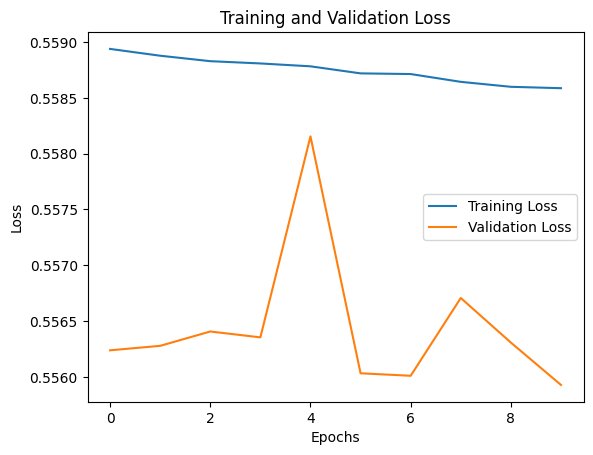

157/157 [==============================] - 1s 8ms/step - loss: 0.5572


0.5571698546409607

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
autoencoder.evaluate(x_test, x_test)

157/157 [==============================] - 1s 7ms/step


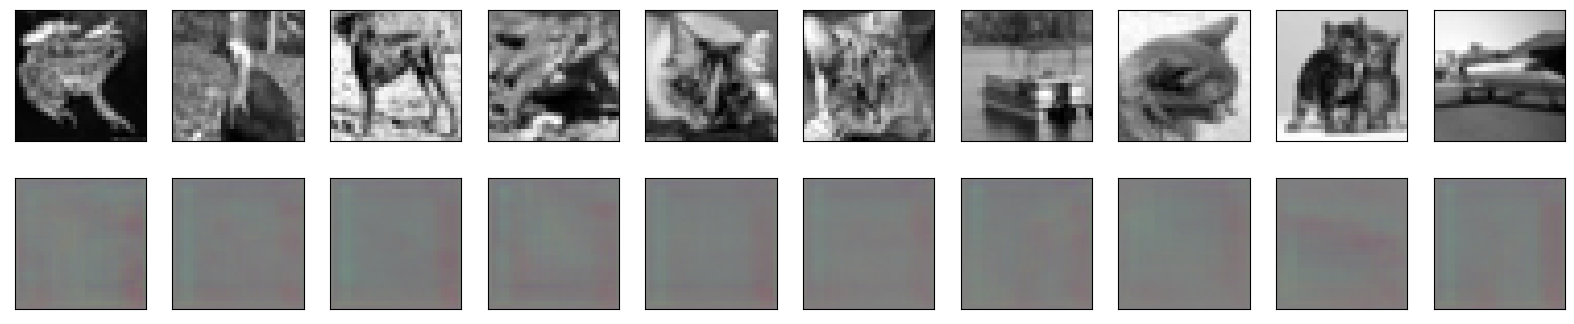

In [82]:
decoded_imgs = autoencoder.predict(x_test)

n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_gray[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [88]:
autoencoder.evaluate(x_test, x_test)

157/157 [==============================] - 1s 7ms/step - loss: 0.5572


0.5571698546409607

In [93]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          1744  

# Exercise 2

In [14]:
layers = [Conv2D, MaxPooling2D, UpSampling2D]

In [40]:
def model_builder(structure, model_params):
    latent_space_sizes = list()
    input_img = Input(shape=(32, 32, 3))
    input_volume = 32
    padding = 1
    ## Set up the first layer
    params = structure[0]["params"]
    x = Conv2D(params[0], params[1], activation=params[3], padding=params[4], strides=params[5])(input_img)
    # calculate layer rep. size for first layer
    input_volume = input_volume / params[2]
    latent_space_sizes.append(get_conv_layer_representation_size(input_volume, params[1][0], padding, params[2], params[0]))

    ## set up the remaining layers
    structure = structure[1:]
    for i,layer in enumerate(structure):
        params = layer["params"]
        if layer["layer"] == 0:
            x = Conv2D(params[0], params[1], activation=params[3], padding=params[4], strides=params[5])(x)
            input_volume = input_volume / params[2]
            latent_space_sizes.append(get_conv_layer_representation_size(input_volume, params[1][0], padding, params[2], params[0]))

        elif layer["layer"] == 1:
            x = MaxPooling2D(params[0], padding=params[1])(x)
            input_volume = input_volume / params[0][0]
        elif layer["layer"] == 2:
            x = UpSampling2D(params[0])(x)
            input_volume = input_volume * params[0][0]
    

    autoencoder = Model(input_img, x)
    autoencoder.compile(optimizer=model_params[0], loss=model_params[1])
    return autoencoder, latent_space_sizes

In [20]:
DEBUG = False
def get_conv_layer_representation_size(W, K, P, S, C):
    if (DEBUG):
        print(f"Volume: {W}, kernel size: {K}, padding: {P}, stride:{S}, channels: {C}")
    return int(((((W - K + (2*P))/S) + 1)**2) * C)

In [28]:
### Model 2
model_structure = [{
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [16, (3,3), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same", (1,1)]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [29]:
model2, latent_space_sizes = model_builder(model_structure, model_params)
print(model2.summary())
print(latent_space_sizes)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 12)        1740  

In [87]:
history = model2.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 43s 132ms/step - loss: 0.8677 - val_loss: 0.5696
Epoch 2/10
313/313 [==============================] - 41s 132ms/step - loss: 0.5697 - val_loss: 0.5631
Epoch 3/10
313/313 [==============================] - 44s 141ms/step - loss: 0.5660 - val_loss: 0.5601
Epoch 4/10
313/313 [==============================] - 39s 126ms/step - loss: 0.5632 - val_loss: 0.5594
Epoch 5/10
313/313 [==============================] - 40s 127ms/step - loss: 0.5682 - val_loss: 0.5589
Epoch 6/10
313/313 [==============================] - 42s 134ms/step - loss: 0.5612 - val_loss: 0.5572
Epoch 7/10
313/313 [==============================] - 40s 129ms/step - loss: 0.5591 - val_loss: 0.5552
Epoch 8/10
313/313 [==============================] - 38s 123ms/step - loss: 0.5578 - val_loss: 0.5545
Epoch 9/10
313/313 [==============================] - 38s 122ms/step - loss: 0.5580 - val_loss: 0.5546
Epoch 10/10
313/313 [==============================] - 39s 123ms/step - l

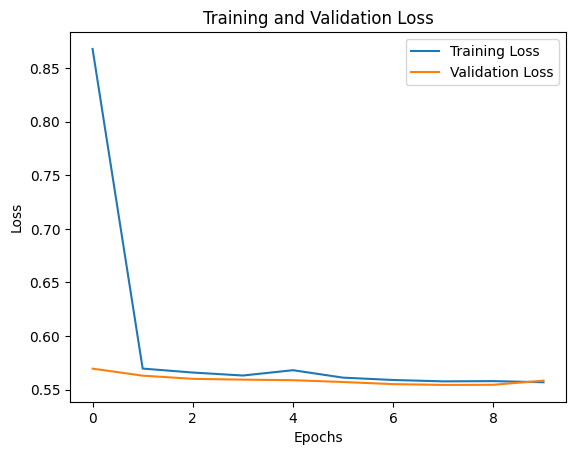

157/157 [==============================] - 1s 9ms/step - loss: 0.5597


0.559653103351593

In [89]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model2.evaluate(x_test, x_test)

In [91]:
### Model 3
model_structure = [{
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [16, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [32, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [92]:
model3, latent_space_sizes = model_builder(model_structure, model_params)
print(model3.summary())
print(latent_space_sizes)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_125 (Conv2D)         (None, 32, 32, 12)        336       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 16, 16, 12)       0         
 g2D)                                                            
                                                                 
 conv2d_126 (Conv2D)         (None, 16, 16, 16)        1744      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_127 (Conv2D)         (None, 8, 8, 32)          464

In [94]:
history = model3.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 40s 122ms/step - loss: 0.6662 - val_loss: 0.5808
Epoch 2/10
313/313 [==============================] - 36s 116ms/step - loss: 0.5805 - val_loss: 0.5742
Epoch 3/10
313/313 [==============================] - 37s 119ms/step - loss: 0.5804 - val_loss: 0.5737
Epoch 4/10
313/313 [==============================] - 38s 121ms/step - loss: 0.5722 - val_loss: 0.5678
Epoch 5/10
313/313 [==============================] - 37s 117ms/step - loss: 0.5710 - val_loss: 0.5666
Epoch 6/10
313/313 [==============================] - 41s 131ms/step - loss: 0.5686 - val_loss: 0.5649
Epoch 7/10
313/313 [==============================] - 37s 118ms/step - loss: 0.5699 - val_loss: 0.5647
Epoch 8/10
313/313 [==============================] - 37s 117ms/step - loss: 0.5704 - val_loss: 0.5702
Epoch 9/10
313/313 [==============================] - 40s 128ms/step - loss: 0.5681 - val_loss: 0.5638
Epoch 10/10
313/313 [==============================] - 39s 126ms/step - l

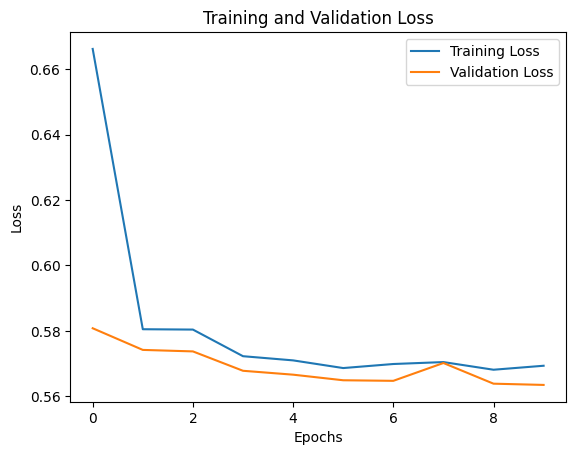

157/157 [==============================] - 1s 8ms/step - loss: 0.5646


0.5646378397941589

In [95]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model3.evaluate(x_test, x_test)

In [98]:
### Model 4
model_structure = [{
        "layer": 0,
        "params": [6, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [99]:
model4, latent_space_sizes = model_builder(model_structure, model_params)
print(model4.summary())
print(latent_space_sizes)

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_130 (Conv2D)         (None, 32, 32, 6)         168       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 16, 16, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_131 (Conv2D)         (None, 16, 16, 8)         440       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 8, 8, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_132 (Conv2D)         (None, 8, 8, 12)          876

In [100]:
history = model4.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 30s 92ms/step - loss: 0.6512 - val_loss: 0.6159
Epoch 2/10
313/313 [==============================] - 27s 85ms/step - loss: 0.5959 - val_loss: 0.5932
Epoch 3/10
313/313 [==============================] - 26s 85ms/step - loss: 0.5904 - val_loss: 0.5855
Epoch 4/10
313/313 [==============================] - 26s 84ms/step - loss: 0.5881 - val_loss: 0.5845
Epoch 5/10
313/313 [==============================] - 27s 86ms/step - loss: 0.5823 - val_loss: 0.5772
Epoch 6/10
313/313 [==============================] - 27s 87ms/step - loss: 0.5800 - val_loss: 0.5780
Epoch 7/10
313/313 [==============================] - 26s 85ms/step - loss: 0.5776 - val_loss: 0.5791
Epoch 8/10
313/313 [==============================] - 27s 86ms/step - loss: 0.5775 - val_loss: 0.5728
Epoch 9/10
313/313 [==============================] - 27s 86ms/step - loss: 0.5755 - val_loss: 0.5718
Epoch 10/10
313/313 [==============================] - 27s 86ms/step - loss: 0.575

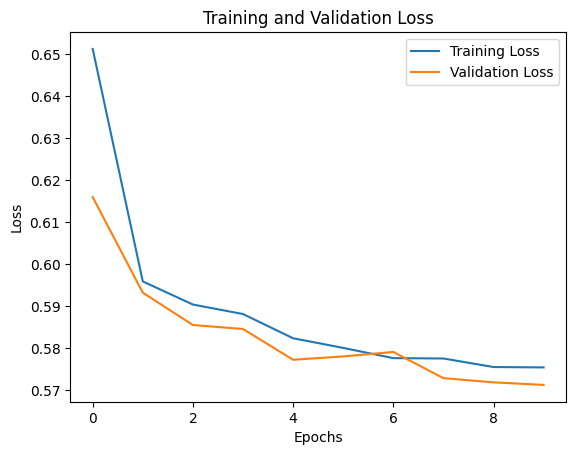

157/157 [==============================] - 1s 9ms/step - loss: 0.5725


0.5724728107452393

In [101]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model4.evaluate(x_test, x_test)

In [103]:
### model 5
model_structure = [{
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [32, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [106]:
model5, latent_space_sizes = model_builder(model_structure, model_params)
print(model5.summary())
print(latent_space_sizes)

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_140 (Conv2D)         (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_141 (Conv2D)         (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_142 (Conv2D)         (None, 8, 8, 32)          348

In [107]:
history = model5.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 40s 121ms/step - loss: 0.6937 - val_loss: 0.5876
Epoch 2/10
313/313 [==============================] - 33s 105ms/step - loss: 0.5889 - val_loss: 0.5816
Epoch 3/10
313/313 [==============================] - 33s 105ms/step - loss: 0.5785 - val_loss: 0.5755
Epoch 4/10
313/313 [==============================] - 33s 106ms/step - loss: 0.5739 - val_loss: 0.5692
Epoch 5/10
313/313 [==============================] - 33s 106ms/step - loss: 0.5715 - val_loss: 0.5671
Epoch 6/10
313/313 [==============================] - 33s 106ms/step - loss: 0.5744 - val_loss: 0.5669
Epoch 7/10
313/313 [==============================] - 33s 107ms/step - loss: 0.5692 - val_loss: 0.5652
Epoch 8/10
313/313 [==============================] - 33s 106ms/step - loss: 0.5690 - val_loss: 0.5653
Epoch 9/10
313/313 [==============================] - 33s 106ms/step - loss: 0.5709 - val_loss: 0.5653
Epoch 10/10
313/313 [==============================] - 33s 106ms/step - l

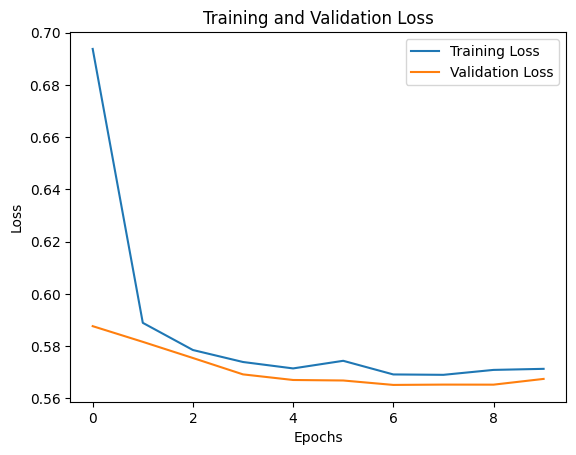

157/157 [==============================] - 1s 8ms/step - loss: 0.5686


0.5686220526695251

In [108]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model5.evaluate(x_test, x_test)

In [111]:
### model 6
model_structure = [{
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [64, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [112]:
model6, latent_space_sizes = model_builder(model_structure, model_params)
print(model6.summary())
print(latent_space_sizes)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_155 (Conv2D)         (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_156 (Conv2D)         (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_157 (Conv2D)         (None, 8, 8, 64)          697

In [113]:
history = model6.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 44s 134ms/step - loss: 0.6283 - val_loss: 0.5815
Epoch 2/10
313/313 [==============================] - 40s 127ms/step - loss: 0.5831 - val_loss: 0.5755
Epoch 3/10
313/313 [==============================] - 40s 128ms/step - loss: 0.5750 - val_loss: 0.5706
Epoch 4/10
313/313 [==============================] - 41s 131ms/step - loss: 0.5745 - val_loss: 0.5751
Epoch 5/10
313/313 [==============================] - 40s 127ms/step - loss: 0.5737 - val_loss: 0.5677
Epoch 6/10
313/313 [==============================] - 42s 133ms/step - loss: 0.5695 - val_loss: 0.5657
Epoch 7/10
313/313 [==============================] - 40s 127ms/step - loss: 0.5701 - val_loss: 0.5646
Epoch 8/10
313/313 [==============================] - 39s 126ms/step - loss: 0.5695 - val_loss: 0.5677
Epoch 9/10
313/313 [==============================] - 39s 126ms/step - loss: 0.5685 - val_loss: 0.5635
Epoch 10/10
313/313 [==============================] - 39s 124ms/step - l

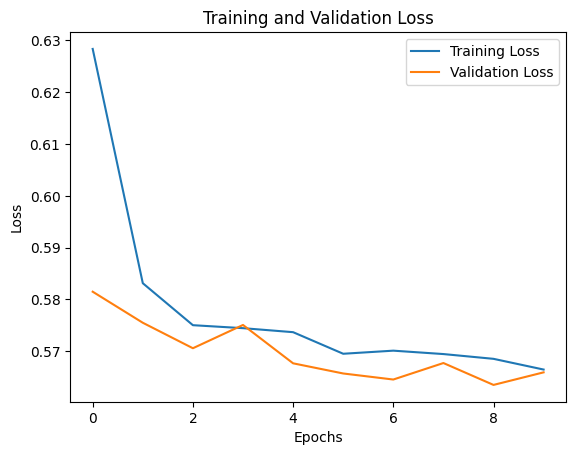

157/157 [==============================] - 2s 11ms/step - loss: 0.5671


0.5671371221542358

In [114]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model6.evaluate(x_test, x_test)

In [115]:
### model 7
model_structure = [{
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [116]:
model7, latent_space_sizes = model_builder(model_structure, model_params)
print(model7.summary())
print(latent_space_sizes)

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_160 (Conv2D)         (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_161 (Conv2D)         (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_162 (Conv2D)         (None, 8, 8, 8)           872

In [117]:
history = model7.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 33s 101ms/step - loss: 0.7067 - val_loss: 0.5949
Epoch 2/10
313/313 [==============================] - 29s 91ms/step - loss: 0.5901 - val_loss: 0.5820
Epoch 3/10
313/313 [==============================] - 29s 92ms/step - loss: 0.5847 - val_loss: 0.5796
Epoch 4/10
313/313 [==============================] - 29s 92ms/step - loss: 0.5804 - val_loss: 0.5764
Epoch 5/10
313/313 [==============================] - 29s 92ms/step - loss: 0.5781 - val_loss: 0.5745
Epoch 6/10
313/313 [==============================] - 28s 91ms/step - loss: 0.5764 - val_loss: 0.5728
Epoch 7/10
313/313 [==============================] - 29s 92ms/step - loss: 0.5750 - val_loss: 0.5716
Epoch 8/10
313/313 [==============================] - 29s 91ms/step - loss: 0.5750 - val_loss: 0.5748
Epoch 9/10
313/313 [==============================] - 29s 93ms/step - loss: 0.5749 - val_loss: 0.5731
Epoch 10/10
313/313 [==============================] - 29s 91ms/step - loss: 0.57

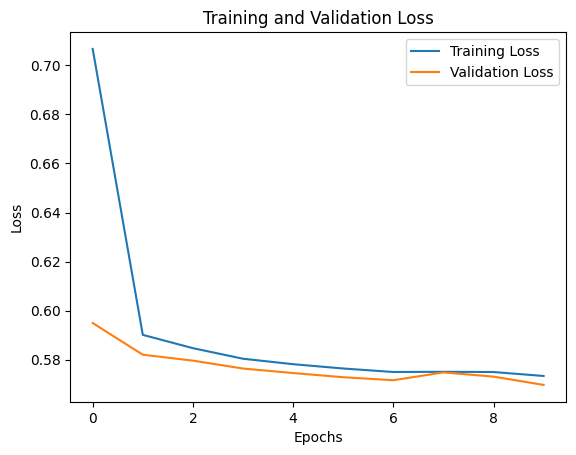

157/157 [==============================] - 1s 8ms/step - loss: 0.5709


0.5708662867546082

In [118]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model7.evaluate(x_test, x_test)

In [120]:
### model 8
model_structure = [{
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [4, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [121]:
model8, latent_space_sizes = model_builder(model_structure, model_params)
print(model8.summary())
print(latent_space_sizes)

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_170 (Conv2D)         (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_171 (Conv2D)         (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_172 (Conv2D)         (None, 8, 8, 4)           436

In [122]:
history = model8.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 30s 89ms/step - loss: 0.7503 - val_loss: 0.6123
Epoch 2/10
313/313 [==============================] - 27s 88ms/step - loss: 0.6038 - val_loss: 0.5934
Epoch 3/10
313/313 [==============================] - 27s 87ms/step - loss: 0.5916 - val_loss: 0.5868
Epoch 4/10
313/313 [==============================] - 28s 90ms/step - loss: 0.5865 - val_loss: 0.5818
Epoch 5/10
313/313 [==============================] - 28s 88ms/step - loss: 0.5845 - val_loss: 0.5798
Epoch 6/10
313/313 [==============================] - 28s 88ms/step - loss: 0.5828 - val_loss: 0.5776
Epoch 7/10
313/313 [==============================] - 27s 87ms/step - loss: 0.5790 - val_loss: 0.5746
Epoch 8/10
313/313 [==============================] - 28s 89ms/step - loss: 0.5761 - val_loss: 0.5721
Epoch 9/10
313/313 [==============================] - 28s 90ms/step - loss: 0.5794 - val_loss: 0.5727
Epoch 10/10
313/313 [==============================] - 33s 106ms/step - loss: 0.57

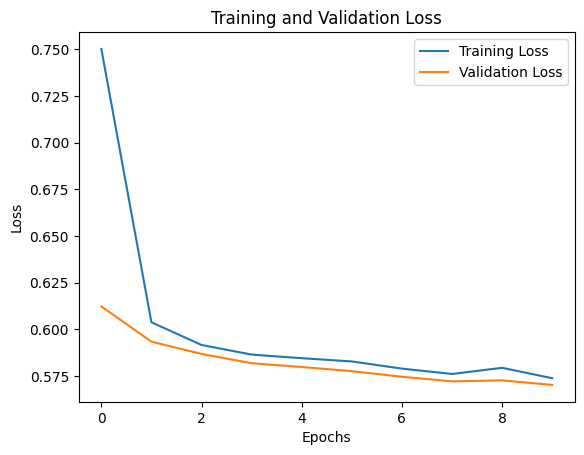

157/157 [==============================] - 1s 8ms/step - loss: 0.5715


0.5715198516845703

In [123]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model8.evaluate(x_test, x_test)

### Varying filter Size of convolutional layer


In [45]:
### filter size 2x2
model_structure_2 = [{
        "layer": 0,
        "params": [8, (2,2), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (2,2), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [16, (2,2), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (2,2), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (2,2), 1, "relu", "same", (1,1)]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [44]:
### filter size 4x4
model_structure_4 = [{
        "layer": 0,
        "params": [8, (4,4), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (4,4), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [16, (4,4), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (4,4), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (4,4), 1, "relu", "same", (1,1)]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [46]:
### filter size 5x5
model_structure_5 = [{
        "layer": 0,
        "params": [8, (5,5), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (5,5), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [16, (5,5), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (5,5), 1, "relu", "same", (1,1)]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (5,5), 1, "relu", "same", (1,1)]
    }
]

model_params = ["adam", "binary_crossentropy"]

In [41]:
model9, latent_space_sizes = model_builder(model_structure_2, model_params)
print(model9.summary())
print(latent_space_sizes)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 8)         104       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 12)        396       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 8, 8, 16)          784 

In [42]:
model10, latent_space_sizes = model_builder(model_structure_4, model_params)
print(model10.summary())
print(latent_space_sizes)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 8)         392       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 12)        1548      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 16)          3088

In [43]:
model11, latent_space_sizes = model_builder(model_structure_5, model_params)
print(model11.summary())
print(latent_space_sizes)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 12)        2412      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 16)          4816

In [47]:
history9 = model9.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

history10 = model10.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

history11 = model11.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
313/313 [==============================] - 31s 95ms/step - loss: 0.7186 - val_loss: 0.5993
Epoch 2/10
313/313 [==============================] - 26s 82ms/step - loss: 0.5937 - val_loss: 0.5867
Epoch 3/10
313/313 [==============================] - 24s 76ms/step - loss: 0.5872 - val_loss: 0.5829
Epoch 4/10
313/313 [==============================] - 22s 71ms/step - loss: 0.5850 - val_loss: 0.5813
Epoch 5/10
313/313 [==============================] - 22s 71ms/step - loss: 0.5820 - val_loss: 0.5879
Epoch 6/10
313/313 [==============================] - 22s 71ms/step - loss: 0.5810 - val_loss: 0.5772
Epoch 7/10
313/313 [==============================] - 22s 70ms/step - loss: 0.5806 - val_loss: 0.5770
Epoch 8/10
313/313 [==============================] - 25s 79ms/step - loss: 0.5784 - val_loss: 0.5753
Epoch 9/10
313/313 [==============================] - 25s 79ms/step - loss: 0.5795 - val_loss: 0.5751
Epoch 10/10
313/313 [==============================] - 22s 70ms/step - loss: 0.577

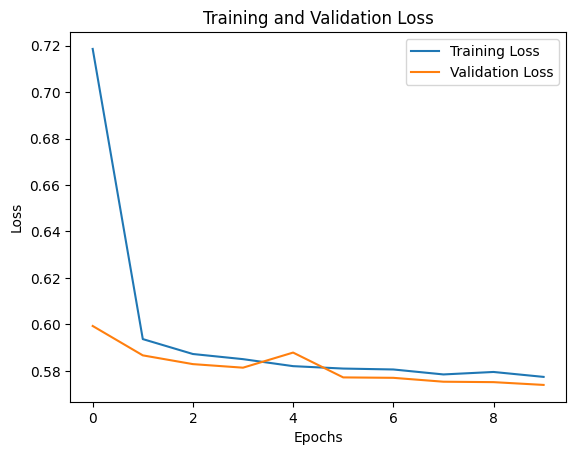

157/157 [==============================] - 1s 6ms/step - loss: 0.5751


0.5751383900642395

In [49]:
plt.plot(history9.history['loss'], label='Training Loss')
plt.plot(history9.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model9.evaluate(x_test, x_test)

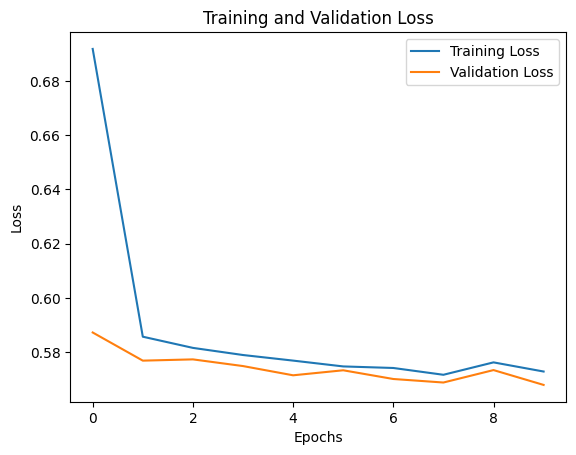

157/157 [==============================] - 2s 11ms/step - loss: 0.5692


0.5691657066345215

In [50]:
plt.plot(history10.history['loss'], label='Training Loss')
plt.plot(history10.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model10.evaluate(x_test, x_test)

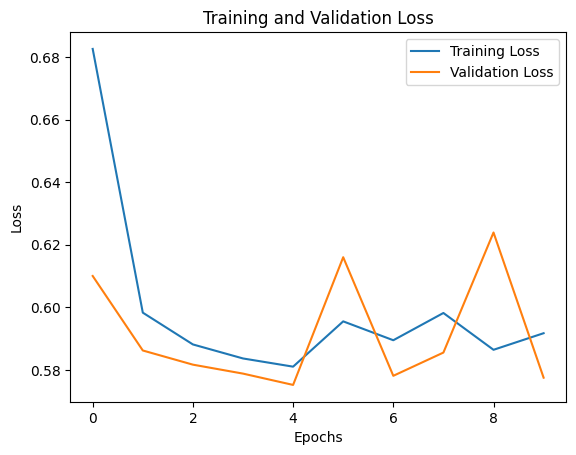

157/157 [==============================] - 2s 13ms/step - loss: 0.5788


0.5788149833679199

In [51]:
plt.plot(history11.history['loss'], label='Training Loss')
plt.plot(history11.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
model11.evaluate(x_test, x_test)

In [58]:
### Save this
model_structure = [{
        "layer": 0,
        "params": [8, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 1,
        "params": [(2,2), "same"]
    },
    {
        "layer": 0,
        "params": [16, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [12, (3,3), 1, "relu", "same"]
    },
    {
        "layer": 2,
        "params": [(2,2)]
    },
    {
        "layer": 0,
        "params": [3, (3,3), 1, "relu", "same"]
    }
]

model_params = ["adam", "binary_crossentropy"]

# Exercise 3

In [118]:
input_img = Input(shape=(32, 32, 1))


x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# At this point, the representation is (8, 8, 16)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [119]:
print(autoencoder.summary())

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_83 (Conv2D)          (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 8, 8, 16)          174

In [120]:
history = autoencoder.fit(x_train_gray, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val_gray, x_val))

Epoch 1/10
313/313 [==============================] - 36s 113ms/step - loss: 0.6025 - val_loss: 0.5804
Epoch 2/10
313/313 [==============================] - 31s 99ms/step - loss: 0.5804 - val_loss: 0.5766
Epoch 3/10
313/313 [==============================] - 32s 103ms/step - loss: 0.5778 - val_loss: 0.5745
Epoch 4/10
313/313 [==============================] - 33s 104ms/step - loss: 0.5765 - val_loss: 0.5731
Epoch 5/10
313/313 [==============================] - 34s 109ms/step - loss: 0.5756 - val_loss: 0.5725
Epoch 6/10
313/313 [==============================] - 34s 110ms/step - loss: 0.5750 - val_loss: 0.5720
Epoch 7/10
313/313 [==============================] - 32s 102ms/step - loss: 0.5746 - val_loss: 0.5716
Epoch 8/10
313/313 [==============================] - 31s 100ms/step - loss: 0.5743 - val_loss: 0.5715
Epoch 9/10
313/313 [==============================] - 30s 96ms/step - loss: 0.5739 - val_loss: 0.5709
Epoch 10/10
313/313 [==============================] - 33s 106ms/step - los

157/157 [==============================] - 1s 9ms/step
wewlad
wewlad
wewlad
wewlad
wewlad
wewlad
wewlad
wewlad
wewlad
wewlad


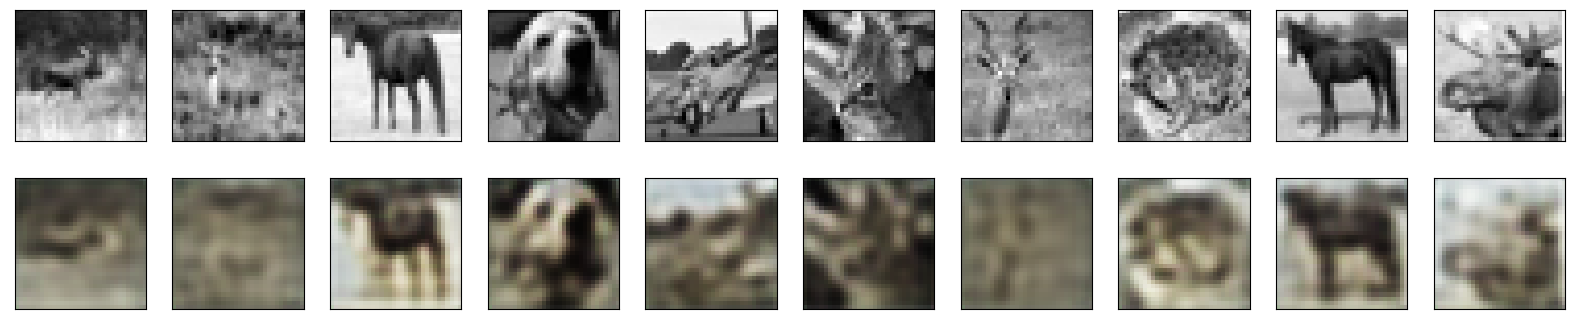

In [122]:
decoded_imgs = autoencoder.predict(x_val_gray)

n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val_gray[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print("wewlad")
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()